In [52]:
### ====> https://www.tensorflow.org/install/pip#windows-native_1
### ====> conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks, preprocessing
from sklearn.model_selection import train_test_split 
from keras.layers import Input, Dense, Conv1D, Flatten
from keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
import keras
import keras_tuner as kt

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# GPU instellen

In [53]:
gpus = tf.config.list_physical_devices('GPU')
print("Beschikbare GPU(s):", gpus)

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:1"])
print("Aantal GPU's:", strategy.num_replicas_in_sync)




Beschikbare GPU(s): []
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1',)
Aantal GPU's: 1


# CSV Import en het Plotten/uitlezen van de CSV

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\AI-Regeling\AppData\Local\Temp\ipykernel_15832\2173541997.py:1: SyntaxWarning: invalid escape sequence '\A'
  CSV_PATH = '/Users\AI-Regeling\CODE\simulatie_resultaten_100001_20250613_115609.csv'


   Tijd (s)  Setpoint (m)  Hoogte (m)      Fout  Fout_Integratie  \
0      0.00      0.431194    0.004019  0.431194         0.004312   
1      0.01      0.431194    0.012057  0.427175         0.008584   
2      0.02      0.431194    0.024114  0.419137         0.012775   
3      0.03      0.431194    0.040190  0.407080         0.016846   
4      0.04      0.431194    0.058491  0.391004         0.020756   

   Fout_Afgeleide       PWM  
0       43.119438  1.000000  
1       -0.401900  1.000000  
2       -0.803800  1.000000  
3       -1.205700  1.000000  
4       -1.607600  0.800694  
Index(['Tijd (s)', 'Setpoint (m)', 'Hoogte (m)', 'Fout', 'Fout_Integratie',
       'Fout_Afgeleide', 'PWM'],
      dtype='object')
           Tijd (s)  Setpoint (m)    Hoogte (m)          Fout  \
count  1.000000e+08  1.000000e+08  1.000000e+08  1.000000e+08   
mean   5.000000e+05  5.256096e-01  5.256095e-01  1.480976e-07   
std    2.886751e+05  2.743203e-01  2.785622e-01  4.860446e-02   
min    0.000000e+00 

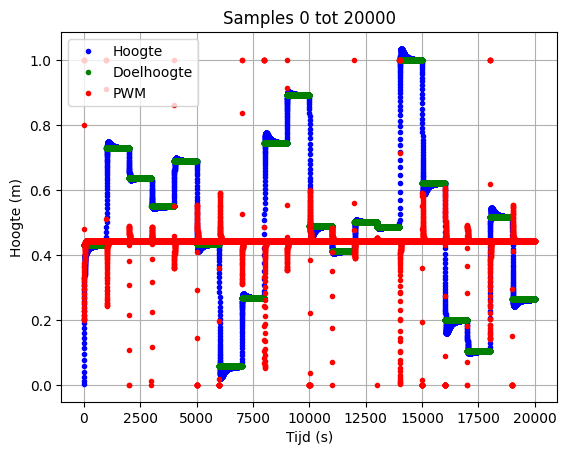

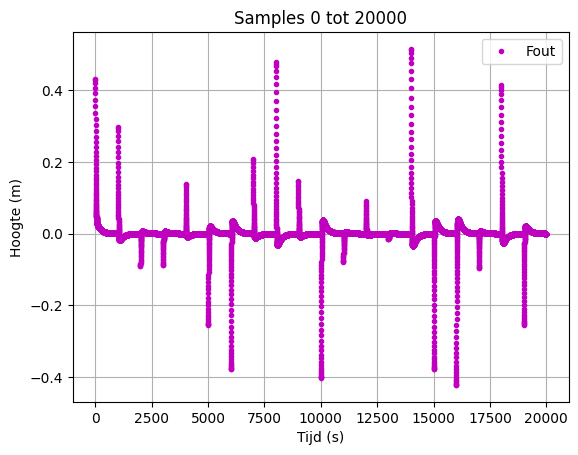

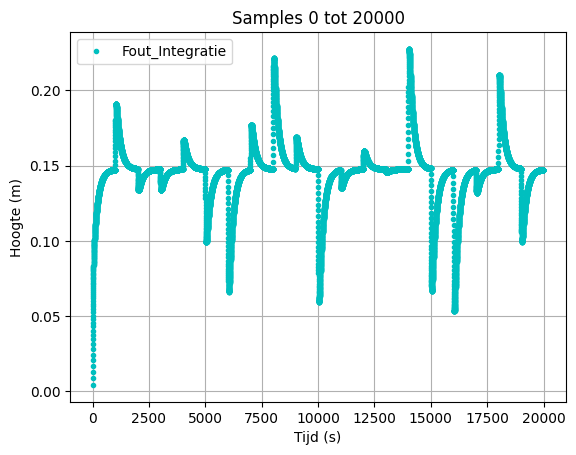

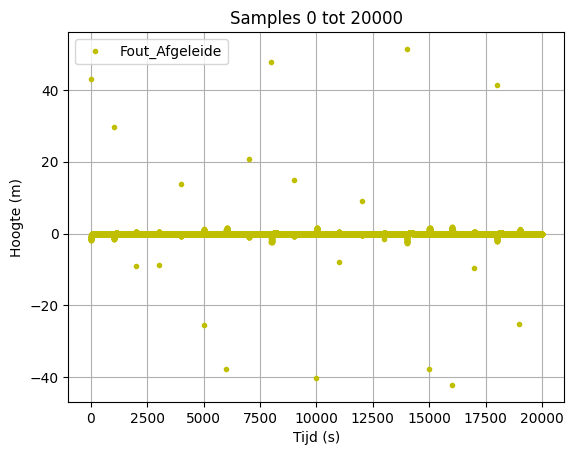

In [54]:
CSV_PATH = '/Users\AI-Regeling\CODE\simulatie_resultaten_100001_20250613_115609.csv'
CSV_DATA = pd.read_csv(CSV_PATH)
print(CSV_DATA.head())
print(CSV_DATA.columns)
print(CSV_DATA.describe())
print(CSV_DATA.info())
print(CSV_DATA.shape)
print(CSV_DATA.dtypes)
print(CSV_DATA.isnull().sum())
print(CSV_DATA.nunique())
print(CSV_DATA.memory_usage(deep=True))
print(CSV_DATA)

# Toon aantal samples
total_samples = len(CSV_DATA)
print(f"Aantal samples: {total_samples}")
print(f"Indexbereik: 0 t/m {total_samples - 1}")

# Dynamisch start en end kiezen
start = 0
end = min(20000, total_samples)

# Veiligheidscheck
if end > start:
    x_range = range(start, end)

    plt.figure()
    plt.plot(x_range, CSV_DATA["Hoogte (m)"][start:end], 'b.', label="Hoogte")
    plt.plot(x_range, CSV_DATA["Setpoint (m)"][start:end], 'g.', label="Doelhoogte")
    plt.plot(x_range, CSV_DATA["PWM"][start:end], 'r.', label="PWM")
    plt.title(f"Samples {start} tot {end}")
    plt.xlabel("Tijd (s)")
    plt.ylabel("Hoogte (m)")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(x_range, CSV_DATA["Fout"][start:end], 'm.', label="Fout")
    plt.title(f"Samples {start} tot {end}")
    plt.xlabel("Tijd (s)")
    plt.ylabel("Hoogte (m)")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(x_range, CSV_DATA["Fout_Integratie"][start:end], 'c.', label="Fout_Integratie")
    plt.title(f"Samples {start} tot {end}")
    plt.xlabel("Tijd (s)")
    plt.ylabel("Hoogte (m)")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(x_range, CSV_DATA["Fout_Afgeleide"][start:end], 'y.', label="Fout_Afgeleide")
    plt.title(f"Samples {start} tot {end}")
    plt.xlabel("Tijd (s)")
    plt.ylabel("Hoogte (m)")
    plt.grid(True)
    plt.legend()

    plt.show()
else:
    print("⚠️ Niet genoeg samples om in dit bereik te plotten.")

# CSV verbinden met input/output trainset

In [55]:
# Selecteer features en target
features = CSV_DATA[['Setpoint (m)', 'Hoogte (m)', 'Fout', 'Fout_Integratie', 'Fout_Afgeleide']].to_numpy()
target = CSV_DATA['PWM'].to_numpy()

# # Normaliseer alleen de features
# feature_scaler = MinMaxScaler()
# features = feature_scaler.fit_transform(features_raw)

# Print informatie
print(f"Features shape: {features.shape}")
print(f"Target shape: {target.shape}\n")

print("🔹 Originele features (eerste 5 samples):")
print(features[:5])

print("\n🔸 Genormaliseerde features (eerste 5 samples):")
print(features[:5])

print("\n🎯 Target (eerste 5 waarden):")
print(target[:5])

# Voor inverse transform later:
# originele_features = feature_scaler.inverse_transform(features)

Features shape: (100000001, 5)
Target shape: (100000001,)

🔹 Originele features (eerste 5 samples):
[[ 4.3119400e-01  4.0190000e-03  4.3119400e-01  4.3120000e-03
   4.3119438e+01]
 [ 4.3119400e-01  1.2057000e-02  4.2717500e-01  8.5840000e-03
  -4.0190000e-01]
 [ 4.3119400e-01  2.4114000e-02  4.1913700e-01  1.2775000e-02
  -8.0380000e-01]
 [ 4.3119400e-01  4.0190000e-02  4.0708000e-01  1.6846000e-02
  -1.2057000e+00]
 [ 4.3119400e-01  5.8491000e-02  3.9100400e-01  2.0756000e-02
  -1.6076000e+00]]

🔸 Genormaliseerde features (eerste 5 samples):
[[ 4.3119400e-01  4.0190000e-03  4.3119400e-01  4.3120000e-03
   4.3119438e+01]
 [ 4.3119400e-01  1.2057000e-02  4.2717500e-01  8.5840000e-03
  -4.0190000e-01]
 [ 4.3119400e-01  2.4114000e-02  4.1913700e-01  1.2775000e-02
  -8.0380000e-01]
 [ 4.3119400e-01  4.0190000e-02  4.0708000e-01  1.6846000e-02
  -1.2057000e+00]
 [ 4.3119400e-01  5.8491000e-02  3.9100400e-01  2.0756000e-02
  -1.6076000e+00]]

🎯 Target (eerste 5 waarden):
[1.       1.       1

In [57]:
n_input = 2  # aantal tijdstappen per voorbeeld

X, y = [], []

for i in range(len(features) - n_input):
    X.append(features[i:i + n_input])
    y.append(target[i + n_input])  # de PWM bij het volgende moment

X = np.array(X)  # shape: (samples, n_input, features)
y = np.array(y)

print("X shape:", X.shape)  # (samples, tijdstappen, features)
print("y shape:", y.shape)  # (samples,)
print("X:", X)  # (samples, tijdstappen, features)
print("y:", y) 

X shape: (99999999, 2, 5)
y shape: (99999999,)
X: [[[ 4.3119400e-01  4.0190000e-03  4.3119400e-01  4.3120000e-03
    4.3119438e+01]
  [ 4.3119400e-01  1.2057000e-02  4.2717500e-01  8.5840000e-03
   -4.0190000e-01]]

 [[ 4.3119400e-01  1.2057000e-02  4.2717500e-01  8.5840000e-03
   -4.0190000e-01]
  [ 4.3119400e-01  2.4114000e-02  4.1913700e-01  1.2775000e-02
   -8.0380000e-01]]

 [[ 4.3119400e-01  2.4114000e-02  4.1913700e-01  1.2775000e-02
   -8.0380000e-01]
  [ 4.3119400e-01  4.0190000e-02  4.0708000e-01  1.6846000e-02
   -1.2057000e+00]]

 ...

 [[ 6.8239800e-01  6.8240500e-01 -7.0000000e-06  1.4766000e-01
    4.0000000e-06]
  [ 6.8239800e-01  6.8240500e-01 -7.0000000e-06  1.4766000e-01
    4.0000000e-06]]

 [[ 6.8239800e-01  6.8240500e-01 -7.0000000e-06  1.4766000e-01
    4.0000000e-06]
  [ 6.8239800e-01  6.8240500e-01 -7.0000000e-06  1.4766000e-01
    4.0000000e-06]]

 [[ 6.8239800e-01  6.8240500e-01 -7.0000000e-06  1.4766000e-01
    4.0000000e-06]
  [ 6.8239800e-01  6.8240500e-01

# het Splitten van de Trainingset en Testset en het weergeven van de Testset op de Trainingset

Test range: index 3000–20002998
Train samples: 80000000
Test samples: 19999999


C:\Users\AI-Regeling\AppData\Local\Temp\ipykernel_15832\720352197.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\AI-Regeling\anaconda3\envs\AI-Systeem-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


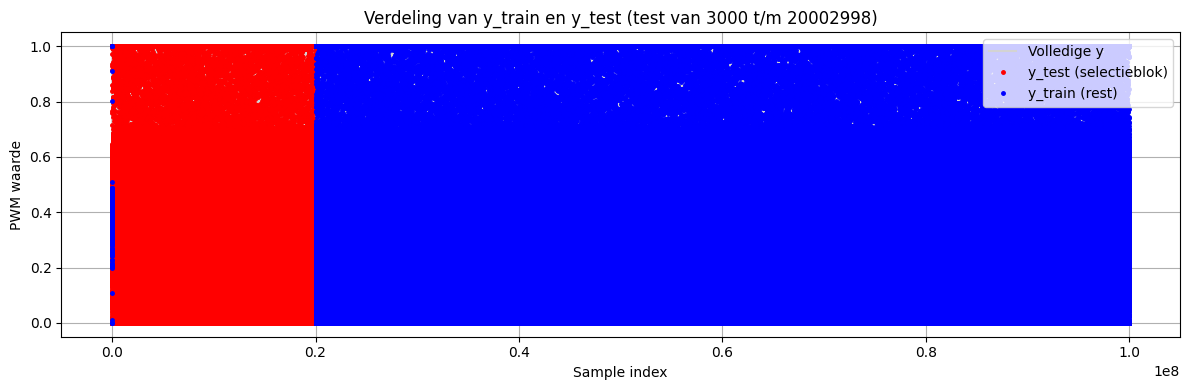

In [58]:
# Lengte van dataset
n = len(y)

# Hoeveel samples is 20%
test_len = int(n * 0.2)

# Kies handmatig waar je testdata begint
test_start = 3000  # bijvoorbeeld index 3000
test_end = test_start + test_len

# Zorg dat je niet buiten de dataset gaat
assert test_end <= n, "Testblok gaat buiten dataset!"

# Slice y en X
X_test, y_test = X[test_start:test_end], y[test_start:test_end]
X_train = np.concatenate((X[:test_start], X[test_end:]), axis=0)
y_train = np.concatenate((y[:test_start], y[test_end:]), axis=0)

print(f"Test range: index {test_start}–{test_end-1}")
print(f"Train samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")


import matplotlib.pyplot as plt

full_indices = np.arange(len(y))
idx_test = np.arange(test_start, test_end)
idx_train = np.setdiff1d(full_indices, idx_test)

plt.figure(figsize=(12, 4))
plt.plot(full_indices, y, color='lightgray', label="Volledige y")
plt.plot(idx_test, y_test, 'r.', label="y_test (selectieblok)", markersize=5)
plt.plot(idx_train, y_train, 'b.', label="y_train (rest)", markersize=5)

plt.title(f"Verdeling van y_train en y_test (test van {test_start} t/m {test_end - 1})")
plt.xlabel("Sample index")
plt.ylabel("PWM waarde")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Aanmaken en compilen met GPU

In [59]:
with strategy.scope():
    model = Sequential([
    Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(n_input, X.shape[2])),  # 8 filters
    Flatten(),
    Dense(56, activation='sigmoid'),  # Hidden layer 1
    Dense(12, activation='sigmoid'),  # Hidden layer 2
    Dense(1)  # Output layer met 8 neuronen
])
    model.compile(optimizer='adam', loss='mse')
    


c:\Users\AI-Regeling\anaconda3\envs\AI-Systeem-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Model Aanmaken (Standaard Versie)

In [60]:
# model = Sequential([
#     Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(n_input, X.shape[2])),  # 8 filters
#     Flatten(),
#     Dense(56, activation='sigmoid'),  # Hidden layer 1
#     Dense(12, activation='sigmoid'),  # Hidden layer 2
#     Dense(1)  # Output layer met 8 neuronen
# ])

# model = Sequential([
#     Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_input, X.shape[2])),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(1)  # Één PWM-waarde voorspellen
# ])

# model = Sequential([
#     Conv1D(filters=8, kernel_size=2, activation='relu', input_shape=(n_input, X.shape[2])),  # 8 filters
#     Flatten(),
#     Dense(8, activation='relu'),  # Hidden layer 1
#     Dense(8, activation='relu'),  # Hidden layer 2
#     Dense(1)  # Output layer met 8 neuronen
# ])

print("n_input:", n_input)
print("X.shape[2]:", X.shape[2])
model.summary()

n_input: 2
X.shape[2]: 5


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 1, 16)          │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 56)             │           952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 12)             │           684 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,825 (7.13 KB)

 Trainable params: 1,825 (7.13 KB)

 Non-trainable params: 0 (0.00 B)

# Model aanmaken (Fine Tuning)

In [ ]:
# def model_builder(hp):
#     model = Sequential()

#     # Conv1D laag met tunable filters en kernel size
#     model.add(Conv1D(
#     filters=hp.Int('filters', 4, 32, step=4),
#     kernel_size=hp.Int('kernel_size', 1, min(n_input, 5), step=1),  # max kernel_size aangepast aan input
#     activation=hp.Choice('conv_activation', ['relu', 'tanh', 'sigmoid']),
#     padding='same',  # voorkomt output <= 0
#     input_shape=(n_input, X.shape[2])
# ))


#     model.add(Flatten())

#     # Hidden Dense layer 1
#     model.add(Dense(
#         units=hp.Int('dense1_units', min_value=4, max_value=64, step=4),
#         activation=hp.Choice('dense1_activation', values=['relu', 'tanh', 'sigmoid'])
#     ))

#     # Hidden Dense layer 2
#     model.add(Dense(
#         units=hp.Int('dense2_units', min_value=4, max_value=64, step=4),
#         activation=hp.Choice('dense2_activation', values=['relu', 'tanh', 'sigmoid'])
#     ))

#     # Output layer (voor regressie zonder activatie of 'sigmoid'/'softmax' voor classificatie)
#     model.add(Dense(1))

#     # Learning rate als hyperparameter
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
#         loss='mse',  # pas aan als je classificatie doet
#         metrics=['mae']  # pas aan indien nodig
#     )

#     return model

# Model Fine tuning

In [ ]:
# tuner = kt.RandomSearch(
#     model_builder,
#     objective='val_mae',  # of 'val_accuracy' bij classificatie
#     max_trials=10,
#     executions_per_trial=1,
#     directory='my_dir',
#     project_name='cnn_dense_tuning'
# )

# tuner.search(X_train, y_train, epochs=1, validation_split=0.2)

# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# print(f"""
# Beste Conv1D filters: {best_hps.get('filters')}
# Beste kernel_size: {best_hps.get('kernel_size')}
# Activatie Conv: {best_hps.get('conv_activation')}
# Dense1: {best_hps.get('dense1_units')} units, activatie: {best_hps.get('dense1_activation')}
# Dense2: {best_hps.get('dense2_units')} units, activatie: {best_hps.get('dense2_activation')}
# Learning rate: {best_hps.get('learning_rate')}
# """)


# Model Compilen (Standaard Versie)

In [ ]:
# model.compile(optimizer='adam', loss='mse')

# Model Trainen

In [61]:
print(tf.config.list_physical_devices('GPU'))
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# model = tuner.hypermodel.build(best_hps)

# history = model.fit(
#     X_train,
#     y_train,
#     epochs=5,
#     batch_size=32,
#     validation_data=(X_test, y_test)
# )

[]
Epoch 1/5
  31917/2500000 ━━━━━━━━━━━━━━━━━━━━ 32:35 792us/step - loss: 0.0270

KeyboardInterrupt: 

# Training en validation loss Plotten

In [ ]:
# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(loss) + 1)


# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# Predict

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Maak voorspellingen
predictions = model.predict(X_test).flatten()

score = model.evaluate(X_test, y_test)
print(f"\n{model.metrics_names[0]} : {score}")

print(f"y_test heeft {len(y_test)} samples (indexbereik: 0 t/m {len(y_test) - 1})")

# Stel de range in
start = 10000
end = min(20000, len(y_test)) 

# Plot alleen het gewenste bereik
plt.figure()
plt.title(f"Predictions vs Actuals (Samples {start}–{end})")
plt.plot(range(start, end), y_test[start:end], 'b.', label='Actual (True PWM)')
plt.plot(range(start, end), predictions[start:end], 'r.', label='Predicted PWM')
plt.xlabel("Sample index")
plt.ylabel("PWM (x100)")
plt.legend()
plt.grid(True)

plt.show()

# Tflite model Export

In [ ]:
model.save("model")


converter = tf.lite.TFLiteConverter.from_saved_model("model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)
print("✅ Model succesvol getraind en geconverteerd(.tflite)")